<a href="https://colab.research.google.com/github/Bryan-Az/TF-PyTorch-Jax-NN/blob/main/Jax-NN/Jax_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Jax API Network
As Jax is essentially a more advanced version of Numpy that can run on any computation device quickly (CPU/TPU/GPU), I will rewrite the model written in numpy using the jax.numpy library. This will help benchmark the difference and test how the model works on a TPU/GPU versus a regular CPU that numpy is used to.


# Imports

In [10]:
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

# Loading and Processing Numerical Features
This will help when processing with the regression model. This data was previously processed in my 'Keras-HF-FastAi' repository when preparing it to be used with the HuggingFace pre-trained "Tabular Question Answering" M.L model. During an earlier processing step when preparing the data for training with FastAi API model-training data loader methods and Sci-kit Learn's "AdaBoostRegressor" model, it was noticed that the data performed better in regression when the original features like working_capacity, fish_production, crop_production_capacity, etc were split into its tuple components, versus when the tuple components were merged into a single feature. This may be due to each component (feature_1, feature_2, etc.) representing a distinct latent variable. For further information for how the data was processed, refert to my 'Keras-HF-FastAi' repository.

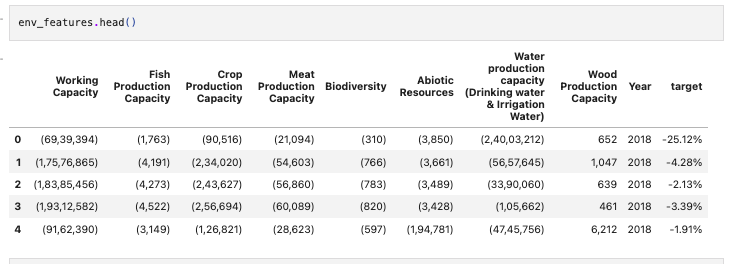

In [4]:
environmental_data = pd.read_csv('../data/corp_safeguard_split.csv')

In [5]:
environmental_data.head()

,working_capacity_0,working_capacity_1,working_capacity_2,working_capacity_3,fish_production_capacity_0,fish_production_capacity_1,crop_production_capacity_0,crop_production_capacity_1,crop_production_capacity_2,meat_production_capacity_0,...,biodiversity_0,biodiversity_1,abiotic_resources_0,abiotic_resources_1,water_production_capacity_(drinking_water_&_irrigation_water)_0,water_production_capacity_(drinking_water_&_irrigation_water)_1,water_production_capacity_(drinking_water_&_irrigation_water)_2,Year,Company Name,target
0,69,39,394.0,445.799955,1,763.0,90,516.0,437.036571,21,...,310,418.64977,3.0,850.0,2,40.0,3.0,2018,APPLUS SERVICES SA,-0.2512
1,1,75,76.0,865.000000,4,191.0,2,34.0,20.000000,54,...,766,418.64977,3.0,661.0,56,57.0,645.0,2018,TELEPERFORMANCE SE,-0.0428
2,1,83,85.0,456.000000,4,273.0,2,43.0,627.000000,56,...,783,418.64977,3.0,489.0,33,90.0,60.0,2018,SGS SA,-0.0213
3,1,93,12.0,582.000000,4,522.0,2,56.0,694.000000,60,...,820,418.64977,3.0,428.0,1,5.0,662.0,2018,INTERTEK GROUP PLC,-0.0339
4,91,62,390.0,445.799955,3,149.0,1,26.0,821.000000,28,...,597,418.64977,1.0,94.0,47,45.0,756.0,2018,THOMSON REUTERS CORP,-0.0191


# Exploratory Data Analysis
We will be looking at the various distributions within the data and selecting three that look promising based on their distribution and the background information. We will then plot them in 3-d space to visualize how they correlate.
The description of each variable is:

'X' features:

1. **Working Capacity**: captures human health effects from climate change, air pollution, and toxicity.

2. **Fish Production Capacity**: includes acidification, eutrophication, climate change, and toxicity.

3. **Crop Production Capacity**: captures soil degradation, air pollution, climate change, and land use.

4. **Meat Production Capacity**: includes soil degradation, climate change, land use, and toxicity.

5. **Biodiversity captures**: land use and toxicity.

6. **Abiotic Resources**: includes environmental impacts from mining.

7. **Water production capacity**: captures climate change, land use, and water pollution.

8. **Wood Production Capacity**: includes climate change, air pollution, and land use.

9. **Company Name**


In [6]:
environmental_data.shape

(13177, 21)

In [7]:
environmental_data.describe()

,working_capacity_0,working_capacity_1,working_capacity_2,working_capacity_3,fish_production_capacity_0,fish_production_capacity_1,crop_production_capacity_0,crop_production_capacity_1,crop_production_capacity_2,meat_production_capacity_0,meat_production_capacity_1,biodiversity_0,biodiversity_1,abiotic_resources_0,abiotic_resources_1,water_production_capacity_(drinking_water_&_irrigation_water)_0,water_production_capacity_(drinking_water_&_irrigation_water)_1,water_production_capacity_(drinking_water_&_irrigation_water)_2,Year,target
count,13177.000000,13177.000000,13177.000000,13177.000000,13177.000000,13177.000000,13177.000000,13177.000000,13177.000000,13177.000000,13177.000000,13177.000000,13177.000000,13177.000000,13177.000000,13177.000000,13177.000000,13177.000000,13177.000000,12421.000000
mean,20.804053,50.554223,194.578280,445.799955,89.416331,400.997112,22.916445,174.273996,437.036571,37.882978,280.593392,156.107005,418.649770,86.520034,357.948948,25.037490,138.152657,333.031578,2014.472186,-2.226546
std,25.360632,50.574416,266.114186,254.009447,200.839185,284.042974,49.858104,254.277964,260.214495,107.415879,302.373033,245.821733,224.246243,195.215095,286.181793,58.735614,221.756658,280.274652,2.505793,35.645920
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2010.000000,-2254.953800
25%,2.000000,23.000000,35.000000,281.000000,3.000000,128.000000,2.000000,30.000000,250.000000,3.000000,44.000000,3.000000,337.000000,3.000000,79.000000,3.000000,28.000000,73.000000,2012.000000,-0.373700
50%,9.000000,47.000000,70.000000,445.799955,10.000000,400.997112,8.000000,64.000000,437.036571,10.000000,96.000000,22.000000,418.649770,11.000000,357.948948,10.000000,58.000000,333.031578,2015.000000,-0.080700
75%,31.000000,73.000000,225.000000,573.000000,44.000000,603.000000,31.000000,128.000000,581.000000,35.000000,500.000000,211.000000,430.000000,47.000000,553.000000,32.000000,91.000000,493.000000,2017.000000,-0.019600
max,99.000000,969.000000,999.000000,999.000000,999.000000,999.000000,997.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,2018.000000,269.504500


In [8]:
numerical_features = environmental_data.drop(['Company Name', 'Year'], axis=1)

/var/folders/b8/b_prs9t152qc96jlgz5zhwt00000gn/T/ipykernel_3482/4069642848.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area.


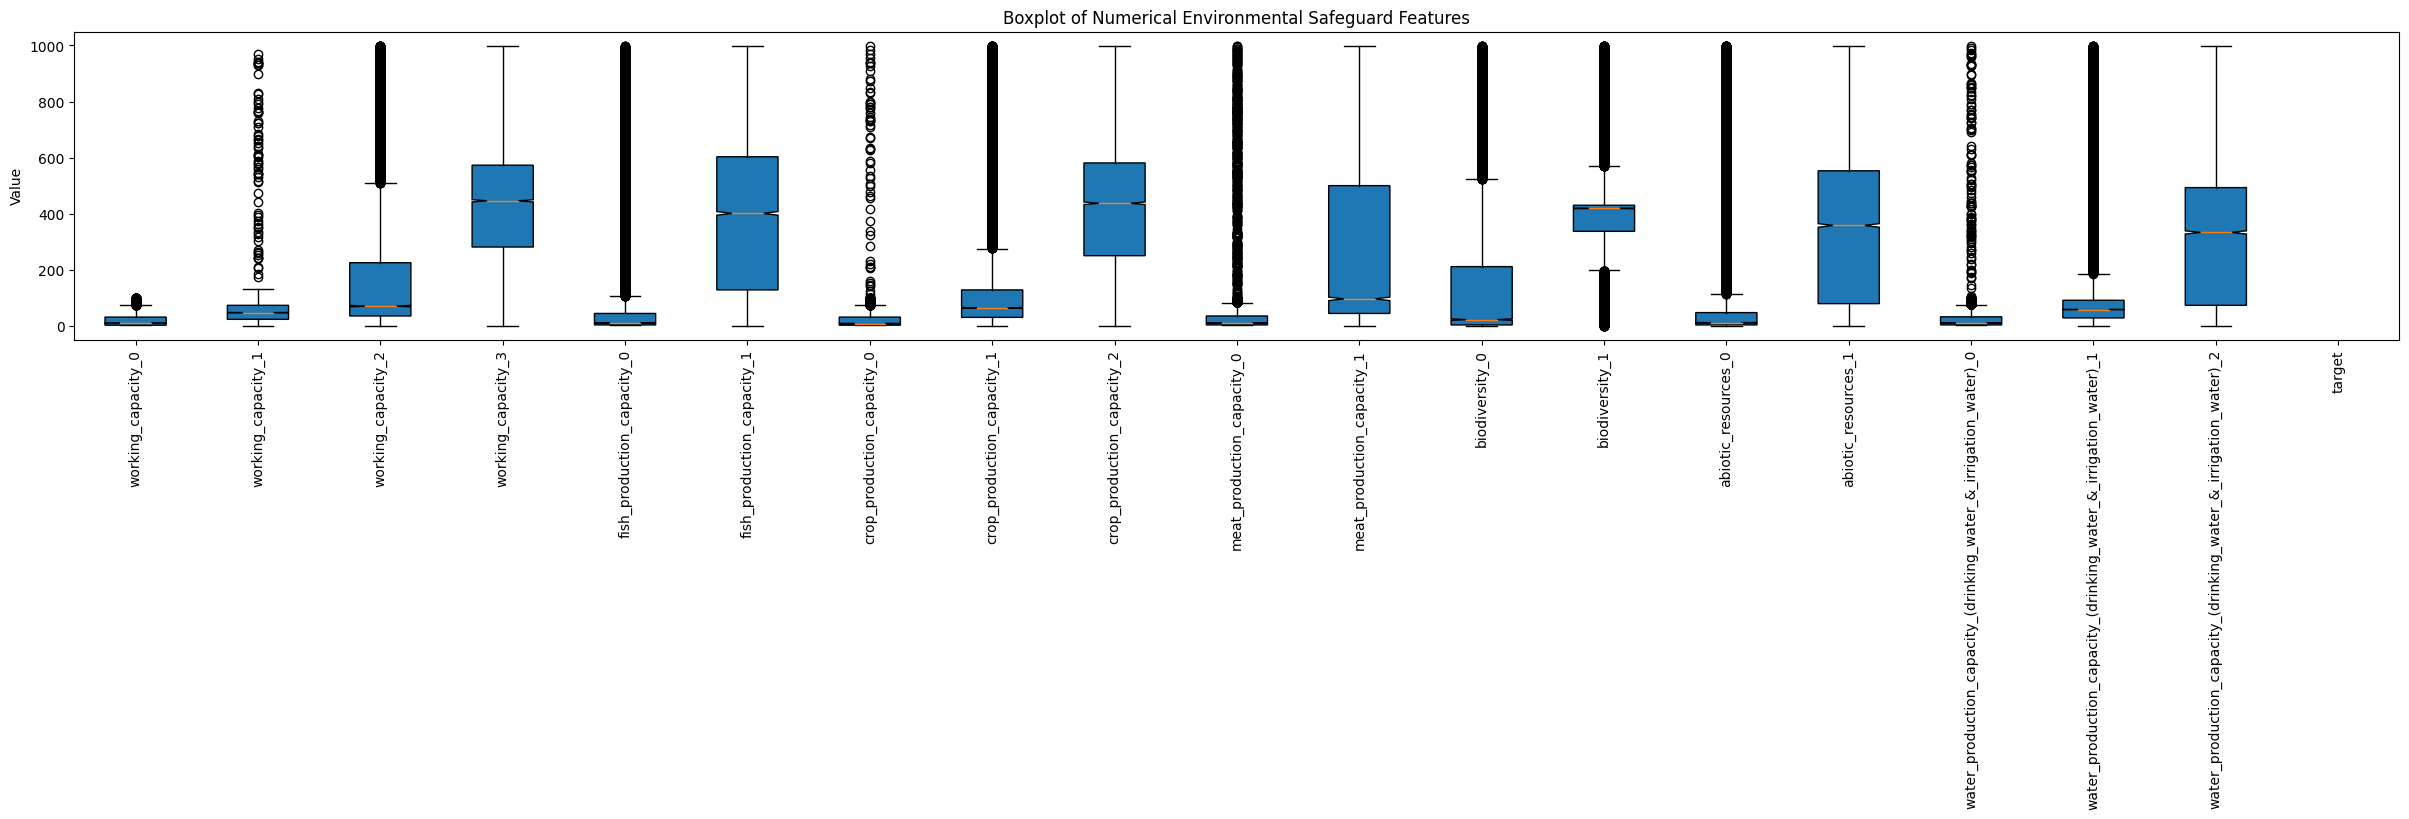

In [11]:
plt.figure(figsize=(30, 4))  # Optional: Adjusts the figure size
plt.boxplot(numerical_features.values, labels=numerical_features.columns, notch=True, patch_artist=True)

# Adding title and labels (optional but recommended for clarity)
plt.title('Boxplot of Numerical Environmental Safeguard Features')
plt.ylabel('Value')
plt.xticks(rotation=90)  # Rotates the x-axis labels to make them more readable

plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.show()

Given the background knowledge of the variables and the above boxplot of their distributions, I will be using:

1.  biodiversity_0 will be used as an X feature as it has information related to the use of land. It also has a larger range in distribution than biodiversity_1 and may also have less outliers. Land usage may impact any buisness - regardless of the buisness field. This may thus give a broader signal than the other variables which may be more related to the company buisness type.
2. working_capacity_3 will also be used as an X feature as it captures the impact the buisness has on people. I selected the working_capacity_3 variable instead of 2 and 3 as it has a larger range than 2, but has no outliers, whereas 2 has many.

In [20]:
X = numerical_features.drop(['target'], axis=1)

Y Target: Total Environmental Intensity (Revenue); The monetized environmental impact of the firm's operations during the specific year indicated in column A divided by revenue in that year.

The Y variables distribution is shown below: 

In [21]:
y = numerical_features.loc[:, 'target']

<Axes: title={'center': 'Line Plot of the Target Variable'}>

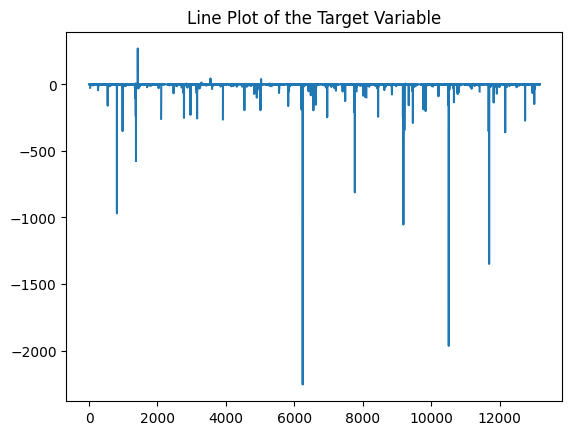

In [22]:
numerical_features.loc[:, 'target'].plot(title='Line Plot of the Target Variable')

We can see that an overwhelming amount of buisnesses have a negative target variable, meaning they have a negative economic impact, or a negative revenue. 

# Scaling the Numerical Data

In [60]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
X_scaled= jnp.array(standard_scaler.fit_transform(X))

In [61]:
y_scaled = jnp.array(standard_scaler.fit_transform(y.to_numpy().reshape(-1, 1)))

# The non-Linear Regression Numpy Model

In [98]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = jnp.nan_to_num(y_pred, nan=0.0)
    self.y_true = jnp.nan_to_num(y_true, nan=0.0)
    return jnp.nanmean((y_pred - y_true) ** 2)

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    # print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient


class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.key = jax.random.PRNGKey(seed=99) 
    self.weights = jax.random.normal(self.key, shape=(input_dim, num_hidden)) * np.sqrt(2. / input_dim)
    self.bias = jnp.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

In [99]:
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = jnp.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      # import pdb; pdb.set_trace()  # By the way, this is how you can debug
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient

In [100]:
class nonLinearModel:
  def __init__(self, input_dim, num_hidden1, num_hidden2, output):
    self.linearlayer1 = Linear(input_dim, num_hidden1)
    self.relu_nonlinear1 = Relu()
    self.linearlayer2 = Linear(num_hidden1, num_hidden2)
    self.relu_nonlinear2 = Relu()
    self.linearlayer3 = Linear(num_hidden2, output)
  
  def __call__(self, x):
    x = jnp.array(x)
    l1 = self.linearlayer1(x)
    r1 = self.relu_nonlinear1(l1)
    l2 = self.linearlayer2(r1)
    r2 = self.relu_nonlinear2(l2)
    l3 = self.linearlayer3(r2)
    return l3
  
  def backward(self, output_gradient):
    output_gradient = jnp.array(output_gradient)
    linear3_gradient = self.linearlayer3.backward(output_gradient)
    relu_nonlinear2_gradient = self.relu_nonlinear2.backward(linear3_gradient)
    linear2_gradient = self.linearlayer2.backward(relu_nonlinear2_gradient)
    relu_nonlinear1_gradient = self.relu_nonlinear1.backward(linear2_gradient)
    linear1_gradient = self.linearlayer1.backward(relu_nonlinear1_gradient)
    # print('Model backward', linear2_gradient.shape, relu_gradient.shape, linear1_gradient.shape)
    # import pdb; pdb.set_trace()
    return linear1_gradient

  def update(self, lr):
    self.linearlayer3.update(lr)
    self.linearlayer2.update(lr)
    self.linearlayer1.update(lr)

In [101]:
loss = MSE()
num_features = X.shape[1]
print(num_features)
threeLayerNonLinearModel = nonLinearModel(num_features, 64, 32, 1)
y_pred = threeLayerNonLinearModel(jnp.array(X_scaled))


18


In [102]:
print(y_pred.shape)
print(y_scaled.shape)

(13177, 1)
(13177, 1)


In [103]:
type(y_pred)

jaxlib.xla_extension.ArrayImpl

In [104]:
type(y_scaled)

jaxlib.xla_extension.ArrayImpl

In [106]:
loss_value = loss(y_pred, y_scaled)
loss_gradient = loss.backward()
print(loss_value)
threeLayerNonLinearModel.backward(loss_gradient)

1.40746


Array([[-2.6957136e-05,  1.5535545e-05,  6.5204156e-05, ...,
        -1.8542771e-05, -2.8081859e-05, -2.4545192e-05],
       [ 4.7799072e-06,  6.4835731e-06, -1.6259386e-06, ...,
         8.3163377e-06,  2.6191785e-06, -1.2241246e-05],
       [ 1.8880387e-06,  6.3535749e-06,  4.5627195e-07, ...,
        -3.4053724e-06, -1.9492559e-06, -1.8216101e-06],
       ...,
       [ 2.1216056e-05, -4.8514439e-06, -7.5231733e-06, ...,
         1.6366730e-05,  2.6908416e-05,  2.8367678e-05],
       [-8.4879002e-06, -1.7768127e-05,  1.8620869e-05, ...,
         1.3536687e-05,  1.0707283e-05, -6.7118654e-06],
       [-1.0171875e-06, -9.5781534e-06, -4.7405533e-06, ...,
         1.0912388e-05, -2.8556500e-05,  4.6152663e-06]], dtype=float32)

In [107]:
threeLayerNonLinearModel.update(0.1)
y_pred = threeLayerNonLinearModel(jnp.array(X_scaled))
loss_value = loss(y_pred, jnp.array(y_scaled))
print(loss_value)

1.2636676


## Training the Model on the Entire Scaled Dataset

Using the metrics defined in the model such as the loss and RMSE

In [108]:
from typing import Callable

In [109]:
def fit(x, y, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    if epoch == (num_epochs -1):
      print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

In [110]:
hidden_layer_trials = [(64,32), (32,64), (50,50), (100, 50), (256,128), (256,128), (128,128), (512,256)]
def run_hiddenlayer_trials(trials):
    loss = MSE()
    num_features = X_scaled.shape[1]
    for trial in trials:
        threeLayerNonLinearModel = nonLinearModel(num_features, trial[0], trial[1], 1)
        print('### Trial with (Layer1Neurons,Layer2Neurons): ', trial)
        print('Third Layer has 1 Neuron (regression)')
        fit(X_scaled, y_scaled, model=threeLayerNonLinearModel, loss=loss, lr=0.01, num_epochs=10)

In [111]:
run_hiddenlayer_trials(hidden_layer_trials)

### Trial with (Layer1Neurons,Layer2Neurons):  (64, 32)
Third Layer has 1 Neuron (regression)
Epoch 9, loss 1.204068660736084
### Trial with (Layer1Neurons,Layer2Neurons):  (32, 64)
Third Layer has 1 Neuron (regression)
Epoch 9, loss 1.2477376461029053
### Trial with (Layer1Neurons,Layer2Neurons):  (50, 50)
Third Layer has 1 Neuron (regression)
Epoch 9, loss 1.163844347000122
### Trial with (Layer1Neurons,Layer2Neurons):  (100, 50)
Third Layer has 1 Neuron (regression)
Epoch 9, loss 1.3135122060775757
### Trial with (Layer1Neurons,Layer2Neurons):  (256, 128)
Third Layer has 1 Neuron (regression)
Epoch 9, loss 1.14969801902771
### Trial with (Layer1Neurons,Layer2Neurons):  (256, 128)
Third Layer has 1 Neuron (regression)
Epoch 9, loss 1.14969801902771
### Trial with (Layer1Neurons,Layer2Neurons):  (128, 128)
Third Layer has 1 Neuron (regression)
Epoch 9, loss 1.1842567920684814
### Trial with (Layer1Neurons,Layer2Neurons):  (512, 256)
Third Layer has 1 Neuron (regression)
Epoch 9, loss 

The result of the neuron size experiment shows (256,128) works best. Lets experiment with the number of epochs.

In [112]:
epochs = [10,20,30,40,50]
def run_epoch_trials(epochs, layer1n=256, layer2n=128):
    loss = MSE()
    num_features = X_scaled.shape[1]
    for trial in epochs:
        threeLayerNonLinearModel = nonLinearModel(num_features, layer1n, layer2n, 1)
        print('### Trial with Epochs#: ', trial)
        fit(X_scaled, y_scaled, model=threeLayerNonLinearModel, loss=loss, lr=0.01, num_epochs=trial)

In [113]:
run_epoch_trials(epochs)

### Trial with Epochs#:  10
Epoch 9, loss 1.14969801902771
### Trial with Epochs#:  20
Epoch 19, loss 1.0906461477279663
### Trial with Epochs#:  30
Epoch 29, loss 1.0677810907363892
### Trial with Epochs#:  40
Epoch 39, loss 1.054275631904602
### Trial with Epochs#:  50
Epoch 49, loss 1.0446341037750244


The above experiments show that hidden layer neurons of (256,128) and 50 trials worked best with the nonlinear regression model with 3 layers. However, this configuration may not be the best every time the trials are reran. So many more trials may need to be ran to find the optimal values. Lets make a final prediction with this configuration and plot the results.

# Evaluating the Results

In [114]:
y_pred = threeLayerNonLinearModel(X_scaled)

In [119]:
X.columns

Index(['working_capacity_0', 'working_capacity_1', 'working_capacity_2',
       'working_capacity_3', 'fish_production_capacity_0',
       'fish_production_capacity_1', 'crop_production_capacity_0',
       'crop_production_capacity_1', 'crop_production_capacity_2',
       'meat_production_capacity_0', 'meat_production_capacity_1',
       'biodiversity_0', 'biodiversity_1', 'abiotic_resources_0',
       'abiotic_resources_1',
       'water_production_capacity_(drinking_water_&_irrigation_water)_0',
       'water_production_capacity_(drinking_water_&_irrigation_water)_1',
       'water_production_capacity_(drinking_water_&_irrigation_water)_2'],
      dtype='object')

In [131]:
def plot_4d(x, y, z, c, title='4D Plot'):
    """ This function plots the 3 X variables 
    as points, and uses color to visualize the target variable.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Assuming x, y, z, and c are numpy arrays or lists of the same length
    # x, y, and z are the coordinates, and c is the color dimension
    ax.scatter(x, y, z, c=c, cmap=plt.hot())
    
    # Add a colorbar to represent the fourth dimension
    fig.colorbar(ax.scatter(x, y, z, c=c, cmap=plt.hot()),ax=ax, label='Environmental Cost Intensity (%)')
    
    plt.title(title)
    plt.show()

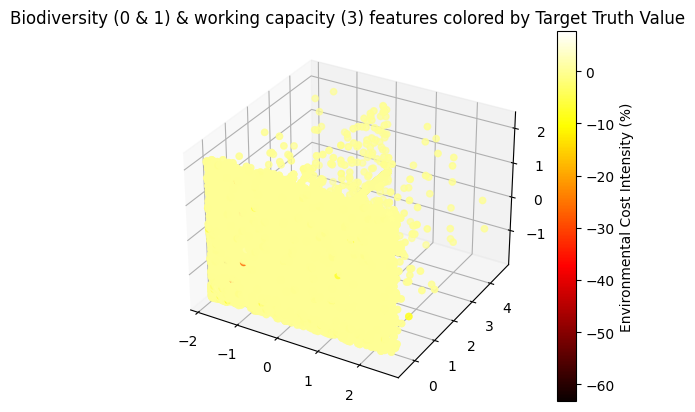

In [139]:
plot_4d(x=X_scaled[:,12],y=X_scaled[:,13], z=X_scaled[:,3], c=y_scaled, title='Biodiversity (0 & 1) & working capacity (3) features colored by Target Truth Value')

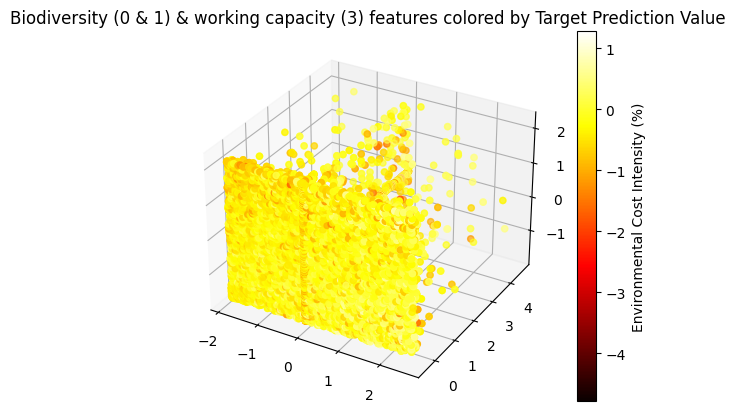

In [140]:
plot_4d(x=X_scaled[:,12],y=X_scaled[:,13], z=X_scaled[:,3], c=y_pred, title='Biodiversity (0 & 1) & working capacity (3) features colored by Target Prediction Value')